In [1]:
# 라이브러리 생성
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray


In [6]:
# # 2100년 TA WS RHM 시간에 대해 평균 3개의 그래프로 공간분포
# path ="/home/papalio/test_research/python_edu/class0/example_0914/"

# file_RHM = "AR6_SSP585_5ENSMN_skorea_RHM_gridraw_daily_2100.nc"
# file_TA = "AR6_SSP585_5ENSMN_skorea_TA_gridraw_daily_2100.nc"
# file_WS = "AR6_SSP585_5ENSMN_skorea_WS_gridraw_daily_2100.nc"

# # 데이터 생성
# ds_RHM = xarray.open_dataset(path+file_RHM)
# ds_TA = xarray.open_dataset(path+file_TA)
# ds_WS = xarray.open_dataset(path+file_WS)

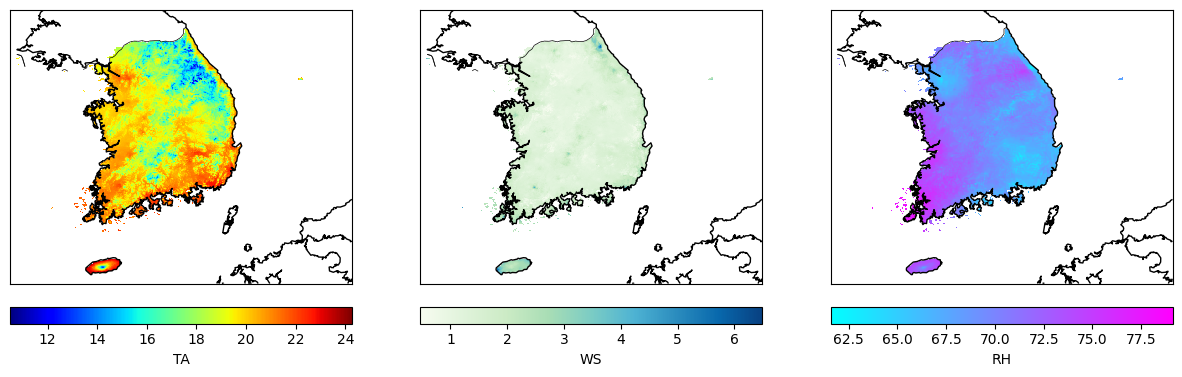

In [ ]:
# ds_ta_mean = ds_TA.mean(dim='time')
# ds_ws_mean = ds_WS.mean(dim='time')
# ds_rh_mean = ds_RHM.mean(dim='time')

# ta_mean = ds_ta_mean['TA']
# ws_mean = ds_ws_mean['WS']
# rh_mean = ds_rh_mean['RHM']

# lon = ds_ta_mean['longitude']
# lat = ds_ta_mean['latitude']
# LON, LAT = np.meshgrid(lon, lat)

# fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,6))
# m1 = Basemap(projection='cyl', resolution='i', llcrnrlon=lon.min(), urcrnrlon=lon.max(), 
#              llcrnrlat=lat.min(), urcrnrlat=lat.max(), ax=axes[0])
# m2 = Basemap(projection='cyl', resolution='i', llcrnrlon=lon.min(), urcrnrlon=lon.max(), 
#              llcrnrlat=lat.min(), urcrnrlat=lat.max(), ax=axes[1])
# m3 = Basemap(projection='cyl', resolution='i', llcrnrlon=lon.min(), urcrnrlon=lon.max(), 
#              llcrnrlat=lat.min(), urcrnrlat=lat.max(), ax=axes[2])

# m1.drawcoastlines()
# m2.drawcoastlines()
# m3.drawcoastlines()
# m1.drawcountries()
# m2.drawcountries()
# m3.drawcountries()

# plot1 = m1.pcolormesh(LON, LAT, ta_mean, cmap='jet', shading='nearest')
# plot2 = m2.pcolormesh(LON, LAT, ws_mean, cmap='GnBu', shading='nearest')
# plot3 = m3.pcolormesh(LON, LAT, rh_mean, cmap='cool', shading='nearest')

# cbar1 = plt.colorbar(plot1, ax=axes[0], location='bottom', orientation='horizontal', pad=0.05, label='TA')
# cbar2 = plt.colorbar(plot2, ax=axes[1], location='bottom', orientation='horizontal', pad=0.05, label='WS')
# cbar3 = plt.colorbar(plot3, ax=axes[2], location='bottom', orientation='horizontal', pad=0.05, label='RH')

# plt.savefig('./exercise_9_1.png')

In [2]:
from dask.distributed import Client

# 로컬 클러스터 설정
client = Client(n_workers=4, threads_per_worker=8, memory_limit='8GB')
print(client)  # 클러스터 상태 출력

<Client: 'tcp://127.0.0.1:45851' processes=4 threads=8, memory=14.90 GiB>


In [3]:
import xarray as xr
import os
from dask.distributed import Client

# Dask 클러스터 설정
client = Client(n_workers=4, threads_per_worker=2, memory_limit="4GB")  # 로컬 클러스터 설정
print(client)  # 클러스터 상태 확인

# THI, DI, WCH 함수 정의
def get_THI(T, RH):
    return 1.8 * T + 32 - 0.55 * (1 - RH / 100) * (1.8 * T - 26)

def get_DI(T, RH):
    return 9 / 5 * T - 0.55 * (1 - RH / 100) * (9 / 5 * T - 26) + 32

def get_WCH(T, V):
    return 13.12 + (0.6215 * T) - (11.37 * V ** 0.16) + (0.3965 * T * V ** 0.16)

# 데이터 위치 및 파일 설정
path = "/home/papalio/test_research/python_edu/class0/example_0914/"
files = {
    "ta_2021": "AR6_SSP585_5ENSMN_skorea_TA_gridraw_daily_2021.nc",
    "ta_2100": "AR6_SSP585_5ENSMN_skorea_TA_gridraw_daily_2100.nc",
    "ws_2021": "AR6_SSP585_5ENSMN_skorea_WS_gridraw_daily_2021.nc",
    "ws_2100": "AR6_SSP585_5ENSMN_skorea_WS_gridraw_daily_2100.nc",
    "rh_2021": "AR6_SSP585_5ENSMN_skorea_RHM_gridraw_daily_2021.nc",
    "rh_2100": "AR6_SSP585_5ENSMN_skorea_RHM_gridraw_daily_2100.nc",
}

# 파일 존재 확인
for key, file in files.items():
    if not os.path.exists(path + file):
        raise FileNotFoundError(f"{file} not found in {path}")

# 데이터 불러오기 및 Dask 활용
ds_ta_2021 = xr.open_dataset(path + files["ta_2021"]).chunk({"time": 100})
ds_ta_2100 = xr.open_dataset(path + files["ta_2100"]).chunk({"time": 100})
ds_ws_2021 = xr.open_dataset(path + files["ws_2021"]).chunk({"time": 100})
ds_ws_2100 = xr.open_dataset(path + files["ws_2100"]).chunk({"time": 100})
ds_rh_2021 = xr.open_dataset(path + files["rh_2021"]).chunk({"time": 100})
ds_rh_2100 = xr.open_dataset(path + files["rh_2100"]).chunk({"time": 100})

# 데이터 변환 및 계산
da_ta_2021, da_ta_2100 = ds_ta_2021["TA"], ds_ta_2100["TA"]
da_ws_2021_kmh, da_ws_2100_kmh = ds_ws_2021["WS"] * 3.6, ds_ws_2100["WS"] * 3.6
da_rh_2021, da_rh_2100 = ds_rh_2021["RHM"], ds_rh_2100["RHM"]

# THI, DI, WCH 계산
THI_2021, THI_2100 = get_THI(da_ta_2021, da_rh_2021), get_THI(da_ta_2100, da_rh_2100)
DI_2021, DI_2100 = get_DI(da_ta_2021, da_rh_2021), get_DI(da_ta_2100, da_rh_2100)
WCH_2021, WCH_2100 = get_WCH(da_ta_2021, da_ws_2021_kmh), get_WCH(da_ta_2100, da_ws_2100_kmh)

# 마스킹
times = da_ta_2021["time"]
mask_DI = (times.dt.month >= 6) & (times.dt.month <= 9)
mask_WCH = (times.dt.month == 1) | (times.dt.month == 2) | (times.dt.month == 11) | (times.dt.month == 12)

DI_2021, DI_2100 = DI_2021[mask_DI.values, :, :], DI_2100[mask_DI.values, :, :]
WCH_2021, WCH_2100 = WCH_2021[mask_WCH.values, :, :], WCH_2100[mask_WCH.values, :, :]

# 결과 저장 (계산 실행 포함)
THI_2021.name, THI_2100.name = "THI", "THI"
DI_2021.name, DI_2100.name = "DI", "DI"
WCH_2021.name, WCH_2100.name = "WCH", "WCH"

THI_2021.compute().to_netcdf("./exercise_9_2_THI_2021.nc")
THI_2100.compute().to_netcdf("./exercise_9_2_THI_2100.nc")
DI_2021.compute().to_netcdf("./exercise_9_2_DI_2021.nc")
DI_2100.compute().to_netcdf("./exercise_9_2_DI_2100.nc")
WCH_2021.compute().to_netcdf("./exercise_9_2_WCH_2021.nc")
WCH_2100.compute().to_netcdf("./exercise_9_2_WCH_2100.nc")


/home/papalio/anaconda3/envs/test_app/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36743 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:37899' processes=4 threads=8, memory=14.90 GiB>
